<h1><center> Active Survey Panel - Churn prediction<h1/><center/>

**Go through to the end of the workbook, play around with the models, create your own and sent me your predictions. I will grade you based on recall score!** 😀

The dataset I provided is a subset of an active survey panel. 

Collected from 3 data sources a customer management database a survey management database and an email tracker software tool.

The data has been preprocessed and cleaned. Some features have been removed on purpose and some feature engineering has been performed already.

The goal it to predict whether a survey participant is likely to unsubscribe.


- RowIndex            = Each row represents a survey participant aka contact of an account.
- Churn               = 0 for Active 1 for Unsub 
- Surveys - Paused On = 0 receiving surveys 1 not receiving 
- Survey Tag          = Survey type

Account information the participant belongs to. Each Account is a paid customer to the survey business.

- Region              = uk region
- Account Type        = type of the account member, target or stakeholder
- Account Value       = value of the account this year 

Emails tracked per participant.

- Clicks_sum          = total number of clicks
- Deliveries_sum      = total number of emails
- Opens_sum           = total number of opening the email


- Time since response = How many days past since last response.    

In [1]:
## Import packages here
import pandas as pd
import numpy as np 
import openpyxl
import imblearn
from matplotlib.pyplot import figure
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from collections import Counter

Loading the dataset

In [2]:
data = pd.read_csv('train_set.csv')

In [3]:
target   = 'Churn'
features = list(data.columns.drop(target))

In [4]:
data['Account Type'].value_counts()

Target         4894
Member          758
Stakeholder       4
Name: Account Type, dtype: int64

In [5]:
data.dtypes

Surveys - Paused On      int64
Survey Tag              object
Region                  object
Account Type            object
Clicks_sum               int64
Deliveries_sum           int64
Opens_sum                int64
Time since response      int64
Account logValue       float64
Churn                    int64
dtype: object

In [6]:
data.shape

(5656, 10)

In [7]:
data.head()

,Surveys - Paused On,Survey Tag,Region,Account Type,Clicks_sum,Deliveries_sum,Opens_sum,Time since response,Account logValue,Churn
0,0,SSS,London,Target,0,0,0,1580,0.0,0
1,1,DTS,East Midlands,Target,0,0,0,1580,0.0,0
2,1,SSS,Thames Valley,Target,0,0,0,1580,0.0,0
3,1,ITS,Yorkshire & the Humber,Target,0,0,0,1580,0.0,0
4,1,SSS,London,Target,0,0,0,1580,0.0,0


In [8]:
data.columns

Index(['Surveys - Paused On', 'Survey Tag', 'Region', 'Account Type',
       'Clicks_sum', 'Deliveries_sum', 'Opens_sum', 'Time since response',
       'Account logValue', 'Churn'],
      dtype='object')

## Visualise the target variable 

<AxesSubplot: >

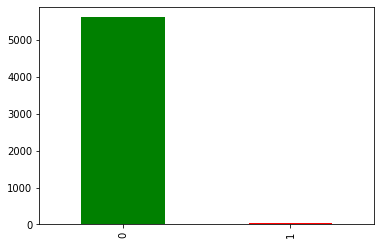

In [9]:
data['Churn'].value_counts().plot.bar(color=['green', 'red'])

In [10]:
data['Churn'].value_counts()

0    5618
1      38
Name: Churn, dtype: int64

We are dealing with unbalanced classes. 

## Scaling - OHC

In [11]:
ohc_cols = data.dtypes == 'object'
num_cols = (data.dtypes == 'float64') | (data.dtypes.apply(str).str.contains('int'))

In [12]:
# Select only object (categorical) columns
categorical_columns = data.columns[ohc_cols]

# Create one-hot encoded columns and concatenate with the original DataFrame
data = pd.concat([data, pd.get_dummies(data.loc[:,categorical_columns], prefix=categorical_columns)], axis=1)

# Drop original categorical columns
data.drop(categorical_columns, axis=1, inplace=True)

## Train test split

In [13]:
X = data[list(data.columns.drop(target))]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [14]:
from sklearn.preprocessing import MinMaxScaler

def transform(x):
    # Copy to avoid warnings & messing up global variables
    x = x.copy()
    scaler         = MinMaxScaler()
    x_scaled       = scaler.fit_transform(x)
    
    return x_scaled

In [15]:
def knn_imputer(x_scaled):
    # KNN inputer for NA's
    imputer        = KNNImputer(n_neighbors=10)

    # Fit the imputer on your dataset and transform it to fill missing values
    x_scaled_imputed = imputer.fit_transform(x_scaled)

    return x_scaled_imputed

In [16]:
X_train_scaled         = transform(X_train)
X_train_scaled_imputed = knn_imputer(X_train_scaled)

In [17]:
X_test_scaled          = transform(X_test)
X_test_scaled_imputed  = knn_imputer(X_test_scaled)

In [18]:
np.isnan(X_train_scaled_imputed).any()

False

In [19]:
np.isnan(X_test_scaled_imputed).any()

False

In [20]:
X_test = X_test_scaled_imputed

In the surveys space companies are fighting to retain even 1 response. Losing even a small number of respondents can make a big difference in the long-term.

We need to make sure we are able to identify those that are going to unsubscribe based on the number of emails they are receiving as well as their commitment to the business.

Starting by evaluating the methods for dealing with unbalanced classes

In [21]:
data['Churn'].value_counts()

0    5618
1      38
Name: Churn, dtype: int64

In [22]:
X_train = X_train_scaled_imputed 

Oversampling the minority class 

In [23]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

Applying weight to the minority class

In [24]:
negative_count = np.sum(y_train == 0)
positive_count = np.sum(y_train == 1)
scale_pos_weight = negative_count / positive_count

Combination of SMORE and undersampling

Minority class data is too small. We are going avoid undersampling. Instead we attempt a middle ground between the original imbalanced dataset and the fully balanced dataset produced by SMOTE.  We will use a combination of SMOTE and random undersampling with ENN.

In [25]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours

# Set the desired sampling strategy for SMOTE and ENN
smote_sampling_strategy = 0.5         # Oversample the minority class to 50% of the majority class
enn_sampling_strategy   = 'majority'  # Clean only the majority class using ENN

# Initialize SMOTE and ENN with custom sampling strategies
smote = SMOTE(sampling_strategy=smote_sampling_strategy)
enn   = EditedNearestNeighbours(sampling_strategy=enn_sampling_strategy)

# Apply SMOTE-ENN with custom sampling strategies
smote_enn = SMOTEENN(smote=smote, enn=enn)
X_train_smoteenn, y_train_smoteenn = smote_enn.fit_resample(X_train, y_train)


In [26]:
X_train.shape

(4524, 27)

In [27]:
X_train_smoteenn.shape

(6524, 27)

In [28]:
X_train_smote.shape

(8988, 27)

To evaluate the approaches will use a simple gradient boosting algorithm and evaluate on the test set.

In [29]:
positive_count/(negative_count +positive_count)

0.006631299734748011

In [30]:
rs = 1
# Grid search hyperparameters for a random forest model
def grid_search_rf(X_train, y_train):
    params_grid = {
    'max_depth': [5, 10, 15, 20],
    'n_estimators': [25, 50, 100],
    'min_samples_split': [2, 5],
    'class_weight': [{0:0.1, 1:0.9}, {0:0.3, 1:0.7},{0:0.04,1:0.96}]
    }
    rf_model    = RandomForestClassifier(random_state=rs)
    grid_search = GridSearchCV(estimator = rf_model, 
                           param_grid = params_grid, 
                           scoring='f1',
                           cv = 5, verbose = 1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params

# Hyperparameter search - Random Forest bagging

## Weighted search 

In [31]:
best_params_rf_weighted = grid_search_rf(X_train,y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


## SMOTE search

In [32]:
best_params_rf_smote =  grid_search_rf(X_train_smote,y_train_smote)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


## SMOTE ENN search

In [33]:
best_params_rf_smoteenn = grid_search_rf(X_train_smoteenn,y_train_smoteenn)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [34]:
# Random forest 
def build_rf(X_train, y_train, X_test, threshold=0.5, best_params=None):
    
    model = RandomForestClassifier(random_state = rs)
    # If best parameters are provided
    if best_params:
        model = RandomForestClassifier(random_state = rs,
                                   # If bootstrap sampling is used
                                   #bootstrap = best_params['bootstrap'],
                                   # Max depth of each tree
                                   max_depth = best_params['max_depth'],
                                   # Class weight parameters
                                   class_weight=best_params['class_weight'],
                                   # Number of trees
                                   n_estimators=best_params['n_estimators'],
                                   # Minimal samples to split
                                   min_samples_split=best_params['min_samples_split'])
    # Train the model   
    model.fit(X_train, y_train)
    # We are on the conservative side so
    # If predicted probability is larger than threshold (default value is 0.5), generate a positive label
    predicted_proba = model.predict_proba(X_test)
    yp = (predicted_proba [:,1] >= threshold).astype('int')
    return yp, model

# Best model fit 

In [35]:
rf_preds_weight, rf_model_weight     = build_rf(X_train, y_train, X_test, best_params=best_params_rf_weighted )
rf_preds_smote, rf_model_smote       = build_rf(X_train_smote, y_train_smote, X_test, best_params=best_params_rf_smote)
rf_preds_smoteenn, rf_model_smoteenn = build_rf(X_train_smoteenn, y_train_smoteenn, X_test, best_params=best_params_rf_smoteenn)

In [36]:
def evaluate(yt, yp,model_type=None):
    results_pos = {}
    # Accuracy
    results_pos['accuracy'] = accuracy_score(yt, yp)
    # Precision, recall, Fscore
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp, beta=5, pos_label=1, average='binary')
    results_pos['recall'] = recall
    # AUC
    results_pos['auc'] = roc_auc_score(yt, yp)
    # Precision
    results_pos['precision'] = precision
    # Fscore
    results_pos['fscore'] = f_beta
    # model type
    results_pos['model type'] = model_type
    return results_pos

## Evaluate on the validation set

In [37]:
results=[]

results.append(evaluate(y_test, rf_preds_weight,model_type='RF_weight'))
results.append(evaluate(y_test, rf_preds_smote,model_type='RF_smote'))
results.append(evaluate(y_test, rf_preds_smoteenn,model_type='RF_smoteenn'))

In [38]:
results = pd.DataFrame(results)
results

,accuracy,recall,auc,precision,fscore,model type
0,0.992049,0.125,0.561610,0.333333,0.128079,RF_weight
1,0.964664,0.125,0.547820,0.029412,0.111111,RF_smote
2,0.941696,0.125,0.536254,0.016667,0.100000,RF_smoteenn


## Load test set

In [39]:
X_test = pd.read_csv('test_set.csv')

In [40]:
X_test.head()

,ID,Surveys - Paused On,Survey Tag,Region,Account Type,Clicks_sum,Deliveries_sum,Opens_sum,Time since response,Account logValue
0,1,0,DTS,East of England,Target,0,0,0,1580,0.000000
1,2,0,ITS,West Midlands,Target,0,0,0,1026,0.000000
2,3,0,SSS,South East,Target,0,0,0,83,0.000000
3,4,0,FSS,Wales,Member,0,0,0,1580,8.328057
4,5,0,FSS,London,Target,0,0,0,377,0.000000


In [41]:
prediction_id = X_test['ID']

In [42]:
X_test = X_test.drop('ID',axis=1)

## Scale test set

In [43]:
ohc_cols = X_test.dtypes == 'object'
num_cols = (X_test.dtypes == 'float64') | (X_test.dtypes.apply(str).str.contains('int'))

In [44]:
# Select only object (categorical) columns
categorical_columns = X_test.columns[ohc_cols]

# Create one-hot encoded columns and concatenate with the original DataFrame
X_test = pd.concat([X_test, pd.get_dummies(X_test.loc[:,categorical_columns], prefix=categorical_columns)], axis=1)

# Drop original categorical columns
X_test.drop(categorical_columns, axis=1, inplace=True)

In [45]:
X_test_scaled         = transform(X_test)
X_test_scaled_imputed = knn_imputer(X_test) 

In [46]:
X_test_scaled_imputed

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

## Make Predictions

In [47]:
rf_preds_smote = rf_model_smote.predict(X_test_scaled_imputed)

## Submit your best prediction! You will be scored using recall

In [48]:
predictions = pd.DataFrame({'id':prediction_id ,'predictions':rf_preds_smote})

In [49]:
predictions.to_csv('submission.csv')

***send me your predictions***

In [50]:
import requests

# Replace this with the path to your submission file
submission_file = 'sample_submission.csv' 

url = 'https://gradingapp.herokuapp.com/submit'

with open(submission_file, 'rb') as f:
    response = requests.post(url, files={'file': f})

if response.status_code == 200:
    print("Success:", response.json())
else:
    print("Error:", response.status_code, response.text)

Success: {'score': 0.6}
